# Image generation with Stable Diffusion XL and OpenVINO

Stable Diffusion XL or SDXL is the latest image generation model that is tailored towards more photorealistic outputs with more detailed imagery and composition compared to previous Stable Diffusion models, including Stable Diffusion 2.1.

With Stable Diffusion XL you can now make more realistic images with improved face generation, produce legible text within images, and create more aesthetically pleasing art using shorter prompts.

![pipeline](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/pipeline.png)

[SDXL](https://arxiv.org/abs/2307.01952) consists of an [ensemble of experts](https://arxiv.org/abs/2211.01324) pipeline for latent diffusion: In the first step, the base model is used to generate (noisy) latents, which are then further processed with a refinement model specialized for the final denoising steps. Note that the base model can be used as a standalone module or in a two-stage pipeline as follows: First, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model and apply a technique called [SDEdit](https://arxiv.org/abs/2108.01073)( also known as "image to image") to the latents generated in the first step, using the same prompt. 

Compared to previous versions of Stable Diffusion, SDXL leverages a three times larger UNet backbone: The increase of model parameters is mainly due to more attention blocks and a larger cross-attention context as SDXL uses a second text encoder. The authors design multiple novel conditioning schemes and train SDXL on multiple aspect ratios and also introduce a refinement model that is used to improve the visual fidelity of samples generated by SDXL using a post-hoc image-to-image technique. The testing of SDXL shows drastically improved performance compared to the previous versions of Stable Diffusion and achieves results competitive with those of black-box state-of-the-art image generators.

In this tutorial, we consider how to run the SDXL model using OpenVINO.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

The tutorial consists of the following steps:

- Install prerequisites
- Download the Stable Diffusion XL Base model from a public source using the [OpenVINO integration with Hugging Face Optimum](https://huggingface.co/blog/openvino).
- Run Text2Image generation pipeline using Stable Diffusion XL base
- Run Image2Image generation pipeline using Stable Diffusion XL base
- Download and convert the Stable Diffusion XL Refiner model from a public source using the [OpenVINO integration with Hugging Face Optimum](https://huggingface.co/blog/openvino).
- Run 2-stages Stable Diffusion XL pipeline

>**Note**: Some demonstrated models can require at least 64GB RAM for conversion and running.

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-xl/stable-diffusion-xl.ipynb" />



#### Table of contents:

- [Install prerequisites](#Install-prerequisites)
- [SDXL Base model](#SDXL-Base-model)
    - [Select inference device SDXL Base model](#Select-inference-device-SDXL-Base-model)
    - [Run Text2Image generation pipeline](#Run-Text2Image-generation-pipeline)
    - [Text2image Generation Interactive Demo](#Text2image-Generation-Interactive-Demo)
    - [Run Image2Image generation pipeline](#Run-Image2Image-generation-pipeline)
        - [Select inference device SDXL Refiner model](#Select-inference-device-SDXL-Refiner-model)
    - [Image2Image Generation Interactive Demo](#Image2Image-Generation-Interactive-Demo)
- [SDXL Refiner model](#SDXL-Refiner-model)
    - [Select inference device](#Select-inference-device)
    - [Run Text2Image generation with Refinement](#Run-Text2Image-generation-with-Refinement)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Install prerequisites
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "torch>=2.1" "torchvision" "diffusers>=0.24.0" "invisible-watermark>=0.2.0" "transformers>=4.33.0" "accelerate" "onnx!=1.16.2" "peft>=0.6.2"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q "openvino>=2023.1.0" "gradio>=4.19" "nncf>=2.9.0"

## SDXL Base model
[back to top ⬆️](#Table-of-contents:)

We will start with the base model part, which is responsible for the generation of images of the desired output size. 
[stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). It already provides a ready-to-use model in OpenVINO format compatible with [Optimum Intel](https://huggingface.co/docs/optimum/intel/index).

To load an OpenVINO model and run an inference with OpenVINO Runtime, you need to replace diffusers `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. In case you want to load a PyTorch model and convert it to the OpenVINO format on the fly, you can set `export=True`.  

You can save the model on disk using the `save_pretrained` method.

In [ ]:
from pathlib import Path
from optimum.intel.openvino import OVStableDiffusionXLPipeline
import gc

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_dir = Path("openvino-sd-xl-base-1.0")

### Select inference device SDXL Base model
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [3]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

Please select below whether you would like to use weight compression to reduce memory footprint. [Optimum Intel](https://huggingface.co/docs/optimum/en/intel/optimization_ov#weight-only-quantization) supports weight compression via NNCF out of the box. For 8-bit compression we provide `quantization_config=OVWeightQuantizationConfig(bits=8, ...)` argument to `from_pretrained()` method containing number of bits and other compression parameters.

In [22]:
import ipywidgets as widgets

compress_weights = widgets.Checkbox(
    description="Apply weight compression",
    value=True,
)

compress_weights

Checkbox(value=True, description='Apply weight compression')

In [24]:
def get_quantization_config(compress_weights):
    quantization_config = None
    if compress_weights.value:
        from optimum.intel import OVWeightQuantizationConfig

        quantization_config = OVWeightQuantizationConfig(bits=8)
    return quantization_config


quantization_config = get_quantization_config(compress_weights)

In [26]:
if not model_dir.exists():
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False, device=device.value, quantization_config=quantization_config)
    text2image_pipe.half()
    text2image_pipe.save_pretrained(model_dir)
    text2image_pipe.compile()
else:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (794 / 794)          | 100% (794 / 794)                  |
+--------------+---------------------------+-----------------------------------+


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (32 / 32)            | 100% (32 / 32)                    |
+--------------+---------------------------+-----------------------------------+


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (40 / 40)            | 100% (40 / 40)                    |
+--------------+---------------------------+-----------------------------------+


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (74 / 74)            | 100% (74 / 74)                    |
+--------------+---------------------------+-----------------------------------+


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (195 / 195)          | 100% (195 / 195)                  |
+--------------+---------------------------+-----------------------------------+


Output()

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the vae_encoder to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...


### Run Text2Image generation pipeline
[back to top ⬆️](#Table-of-contents:)

Now, we can run the model for the generation of images using text prompts. To speed up evaluation and reduce the required memory we decrease `num_inference_steps` and image size (using `height` and `width`).  You can modify them to suit your needs and depend on the target hardware. We also specified a `generator` parameter based on a numpy random state with a specific seed for results reproducibility.

  0%|          | 0/15 [00:00<?, ?it/s]

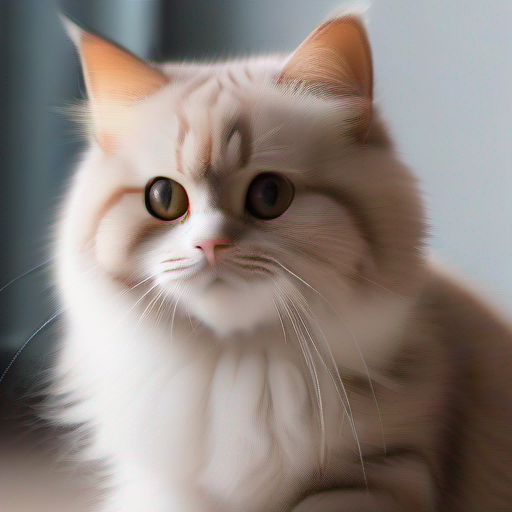

In [27]:
import numpy as np

prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
image = text2image_pipe(
    prompt,
    num_inference_steps=15,
    height=512,
    width=512,
    generator=np.random.RandomState(314),
).images[0]
image.save("cat.png")
image

### Text2image Generation Interactive Demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
import requests

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-xl/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo_sd_xl_text2image

if text2image_pipe is None:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

demo = make_demo_sd_xl_text2image(text2image_pipe)

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
# if you want create public link for sharing demo, please add share=True
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)

In [ ]:
demo.close()
text2image_pipe = None
gc.collect();

### Run Image2Image generation pipeline
[back to top ⬆️](#Table-of-contents:)

We can reuse the already converted model for running the Image2Image generation pipeline. For that, we should replace `OVStableDiffusionXLPipeline` with `OVStableDiffusionXLImage2ImagePipeline`.

#### Select inference device SDXL Refiner model
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [9]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline

image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir, device=device.value)

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the vae_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the text_encoder to AUTO ...


  0%|          | 0/7 [00:00<?, ?it/s]

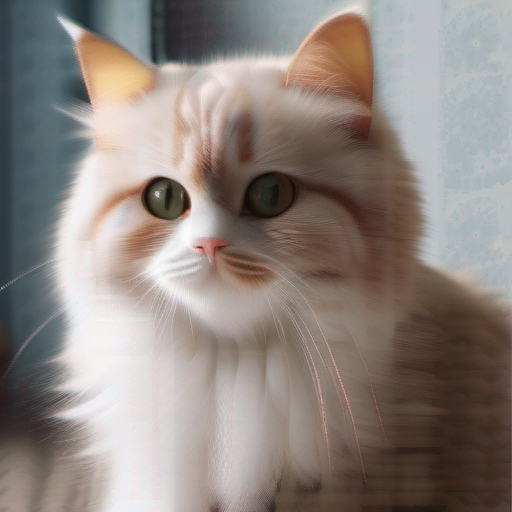

In [10]:
photo_prompt = "professional photo of a cat, extremely detailed, hyper realistic, best quality, full hd"
photo_image = image2image_pipe(
    photo_prompt,
    image=image,
    num_inference_steps=25,
    generator=np.random.RandomState(356),
).images[0]
photo_image.save("photo_cat.png")
photo_image

### Image2Image Generation Interactive Demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-xl/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo_sd_xl_image2image

if image2image_pipe is None:
    image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir)

demo = make_demo_sd_xl_image2image(image2image_pipe)

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
# if you want create public link for sharing demo, please add share=True
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)

In [ ]:
demo.close()
del image2image_pipe
gc.collect()

## SDXL Refiner model
[back to top ⬆️](#Table-of-contents:)

As we discussed above, Stable Diffusion XL can be used in a 2-stages approach: first, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model for the refinement of latents generated in the first step, using the same prompt. 
The Stable Diffusion XL Refiner model is designed to transform regular images into stunning masterpieces with the help of user-specified prompt text. It can be used to improve the quality of image generation after the Stable Diffusion XL Base. The refiner model accepts latents produced by the SDXL base model and text prompt for improving generated image.

select whether you would like to use weight compression to reduce memory footprint

In [ ]:
compress_weights

In [ ]:
quantization_config = get_quantization_config(compress_weights)

In [ ]:
from optimum.intel import (
    OVStableDiffusionXLImg2ImgPipeline,
    OVStableDiffusionXLPipeline,
)
from pathlib import Path

refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"
refiner_model_dir = Path("openvino-sd-xl-refiner-1.0")


if not refiner_model_dir.exists():
    refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, export=True, compile=False, quantization_config=quantization_config)
    refiner.half()
    refiner.save_pretrained(refiner_model_dir)
    del refiner
    gc.collect()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [14]:
device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

### Run Text2Image generation with Refinement
[back to top ⬆️](#Table-of-contents:)


In [15]:
import numpy as np
import gc

model_dir = Path("openvino-sd-xl-base-1.0")
base = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
latents = base(
    prompt,
    num_inference_steps=15,
    height=512,
    width=512,
    generator=np.random.RandomState(314),
    output_type="latent",
).images[0]

del base
gc.collect()

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


  0%|          | 0/15 [00:00<?, ?it/s]

294

In [16]:
refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_dir, device=device.value)

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


  0%|          | 0/4 [00:00<?, ?it/s]

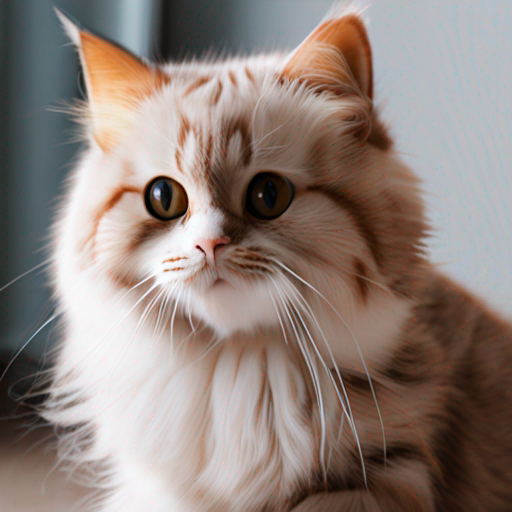

In [17]:
image = refiner(
    prompt=prompt,
    image=np.transpose(latents[None, :], (0, 2, 3, 1)),
    num_inference_steps=15,
    generator=np.random.RandomState(314),
).images[0]
image.save("cat_refined.png")

image